# What variables differentially affect change in state uninsured rates post Affordable Care Act?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re #regular expressions
import scipy.stats
import datetime as dt
%matplotlib inline
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn  import preprocessing
from sklearn.decomposition import PCA 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

The rate of uninsured individuals fell considerably post implementation of the Affordable Care Act. There is large variability in the effect size between states. This project will aim to explore what variables can potentially describe the variance in effect size. Understanding the variance in these changes could inform future legislation and could also be used to target externalities in the provision of healthcare.

In [3]:
state_aca_df = pd.read_csv('states.csv')

In [4]:
#need to convert percentage strings to integer

state_aca_df['uninsured_rate_change']=state_aca_df.uninsured_rate_change.str.replace("%", "")

state_aca_df['uninsured_rate_change']=state_aca_df['uninsured_rate_change'].apply(pd.to_numeric)

state_aca_df['uninsured_rate_2010']=state_aca_df.uninsured_rate_2010.str.replace("%", "")

state_aca_df['uninsured_rate_2010']=state_aca_df['uninsured_rate_2010'].apply(pd.to_numeric)

state_aca_df['uninsured_rate_2015']=state_aca_df.uninsured_rate_2015.str.replace("%", "")

state_aca_df['uninsured_rate_2015']=state_aca_df['uninsured_rate_2015'].apply(pd.to_numeric)

#quick check

#state_aca_df.head()


------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------

## Feature Engineering and cleaning:

In [5]:
#create variable that describes politcal lean of state
#data taken from https://news.gallup.com/poll/181475/massachusetts-maryland-democratic-states.aspx?utm_source=Politics&utm_medium=newsfeed&utm_campaign=tiles
state_aca_df['State']=state_aca_df.State.str.replace(" ", "")
state_aca_df['State']=state_aca_df.State.str.lower()

#Create new binrary variable for political lean
#state_aca_df['political_lean']=np.where((state_aca_df['State'].isin(['california','washington','newmexico',
                                                                     #'michigan','illinois','oregon','pennsylvania', 'newyork',
                                                                     #'maryland','delaware','newjersey','conneticut','rhodeisland',
                                                                     #'massacheusets','vermont','newhampshire','maine','hawaii'])), 1, 0)

#might be better to create a categorical variable that includes neutral states
political_lean=[]

for row in state_aca_df['State']:
    # if more than a value,
    if row in ['california','washington','newmexico','michigan','illinois','oregon','pennsylvania', 'newyork',
               'maryland','delaware','newjersey','conneticut','rhodeisland','massacheusets','vermont','newhampshire','maine','hawaii']:
        # Append a scaled variable where 2=left leaning
        political_lean.append('2')
    # else, if more than a value,
    elif row in ['alaska','utah','wyoming','indiana','arizona','tennessee','montana','northdakota','southdakota','nebraska','kansas','mississipi','alabama']:
        # Append a scaled variable where 0= right leaning
        political_lean.append('0')
    # append a scaled variable where 1=neutral political lean
    else:
        political_lean.append('1')
    #create a column based on this output
state_aca_df['political_lean'] = political_lean
            
            
#quick check
#print(state_aca_df['political_lean'])

In [6]:
#type above is an object..need to cast that to an integer

state_aca_df['political_lean']=state_aca_df['political_lean'].apply(pd.to_numeric)

#create a variable that describes state GDP per capita

gdp_per_cap_df = pd.read_csv('gdp_per_capita_USA_2010_2015.csv')

state_aca_df['gdppercap_2010']=gdp_per_cap_df['gdppercap_2010']
state_aca_df['gdppercap_2011']=gdp_per_cap_df['gdppercap_2011']
state_aca_df['gdppercap_2012']=gdp_per_cap_df['gdppercap_2012']
state_aca_df['gdppercap_2013']=gdp_per_cap_df['gdppercap_2013']
state_aca_df['gdppercap_2014']=gdp_per_cap_df['gdppercap_2014']
state_aca_df['gdppercap_2015']=gdp_per_cap_df['gdppercap_2015']

#KFF.org has a lot of descriptive data on state healthcare status, i'm going to add some of that data for future analyses

kff_df= pd.read_csv('kff_data.csv')
#remove $ signs
kff_df['health_expense_per_cap_2014']=kff_df.health_expense_per_cap_2014.str.replace("$", "")
kff_df['health_expense_per_cap_2013']=kff_df.health_expense_per_cap_2013.str.replace("$", "")
kff_df['health_expense_per_cap_2012']=kff_df.health_expense_per_cap_2012.str.replace("$", "")
kff_df['health_expense_per_cap_2011']=kff_df.health_expense_per_cap_2011.str.replace("$", "")
kff_df['health_expense_per_cap_2010']=kff_df.health_expense_per_cap_2010.str.replace("$", "")
kff_df['health_expense_per_cap_2009']=kff_df.health_expense_per_cap_2009.str.replace("$", "")
kff_df['private_health_insurance_spending_millions']=kff_df.private_health_insurance_spending_millions.str.replace("$", "")
#remove ,
kff_df['health_expense_per_cap_2014']=kff_df.health_expense_per_cap_2014.str.replace(",", "")
kff_df['health_expense_per_cap_2013']=kff_df.health_expense_per_cap_2013.str.replace(",", "")
kff_df['health_expense_per_cap_2012']=kff_df.health_expense_per_cap_2012.str.replace(",", "")
kff_df['health_expense_per_cap_2011']=kff_df.health_expense_per_cap_2011.str.replace(",", "")
kff_df['health_expense_per_cap_2010']=kff_df.health_expense_per_cap_2010.str.replace(",", "")
kff_df['health_expense_per_cap_2009']=kff_df.health_expense_per_cap_2009.str.replace(",", "")
kff_df['private_health_insurance_spending_millions']=kff_df.private_health_insurance_spending_millions.str.replace(",", "")
#create corresponding variables in original database
state_aca_df['health_expense_per_cap_2014']=kff_df['health_expense_per_cap_2014'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2013']=kff_df['health_expense_per_cap_2013'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2012']=kff_df['health_expense_per_cap_2012'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2011']=kff_df['health_expense_per_cap_2011'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2010']=kff_df['health_expense_per_cap_2010'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2009']=kff_df['health_expense_per_cap_2009'].apply(pd.to_numeric)
state_aca_df['private_health_insurance_spending_millions']=kff_df['private_health_insurance_spending_millions'].apply(pd.to_numeric)

#add federal poverty line distributions for each state
state_aca_df['2015_under_fed_pl']=kff_df['2015_under_fed_pl']
state_aca_df['2010_under_fed_pl']=kff_df['2010_under_fed_pl']

state_aca_df['2015_100_199_fedpl']=kff_df['2015_100_199_fedpl']
state_aca_df['2010_100_199_fedpl']=kff_df['2010_100_199_fedpl']

state_aca_df['2015_200_399_fedpl']=kff_df['2015_200_399_fedpl']
state_aca_df['2010_200_399_fedpl']=kff_df['2010_200_399_fedpl']

state_aca_df['2015_over400_pl']=kff_df['2015_over400_pl']
state_aca_df['2010_over400_pl']=kff_df['2010_over400_pl']

In [7]:
#cleaning I missed

state_aca_df['average_monthly_tax_credit_2016']=state_aca_df['average_monthly_tax_credit_2016'].str.replace("$", "")
state_aca_df['average_monthly_tax_credit_2016']=state_aca_df['average_monthly_tax_credit_2016'].apply(pd.to_numeric)

In [8]:
politics_poverty = pd.DataFrame()
politics_poverty['political_lean']=state_aca_df['political_lean']
politics_poverty['underfpl']=state_aca_df['2015_under_fed_pl']
politics_poverty['100199fpl']=state_aca_df['2015_100_199_fedpl']
politics_poverty['over400fpl']=state_aca_df['2015_over400_pl']


scaled_politics_poverty=preprocessing.scale(politics_poverty)

pca = PCA()
pca.fit(scaled_politics_poverty)
pca_data = pca.transform(scaled_politics_poverty)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


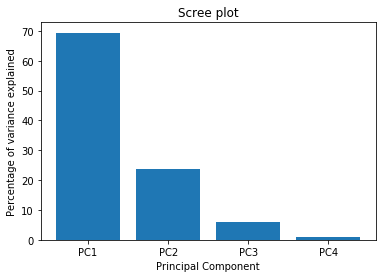

[[ 2.50815114e+00 -7.85628631e-01  8.56116469e-01 -6.29764062e-02]
 [-1.41382929e+00 -1.81749310e+00  1.16764887e-01  2.24015408e-01]
 [ 1.56678130e+00 -1.10336318e+00  3.60417597e-01  6.65105005e-02]
 [ 2.82469547e+00  5.59917616e-01  1.68225644e-01  1.03626999e-01]
 [-8.13642558e-02  1.26257574e+00 -2.10244989e-01  4.17196232e-01]
 [-1.37451159e+00 -4.28342186e-01 -3.94101706e-02 -3.26307476e-02]
 [-2.79986837e+00 -6.03593150e-01  5.71036758e-01  7.57780018e-02]
 [-1.23667068e+00  1.05837978e+00  1.29055133e-01 -2.36847819e-01]
 [-1.54989807e+00 -6.34063282e-02  1.67492607e+00  3.76424163e-01]
 [ 1.29164399e+00  1.18936687e-01 -2.98786214e-01  2.92587820e-01]
 [ 1.45345725e+00  2.86441663e-01  3.29137375e-01 -1.52644949e-02]
 [-2.51855720e+00  7.14315966e-01 -1.38211200e-01 -1.70329075e-01]
 [ 1.79783326e+00  7.43511218e-02 -1.01784424e+00  4.53530640e-01]
 [-7.21309907e-01  1.18195312e+00  1.62815537e-01 -2.08886153e-01]
 [ 1.02921820e+00 -1.32483455e+00 -6.04305872e-02 -1.01315828e

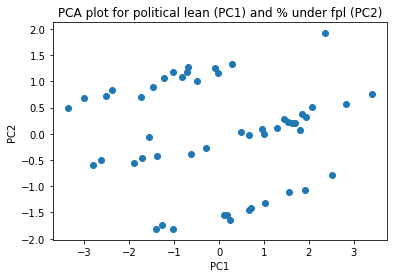

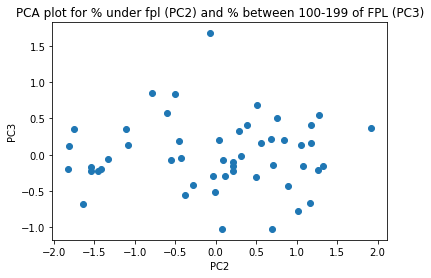

In [9]:
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of variance explained')
plt.xlabel('Principal Component')
plt.title('Scree plot')
plt.show()

# at 850 in video www.youtube.com/watch?v=Lsue2gEM9D0
print(pca_data)

politics_poverty_pca_df = pd.DataFrame(pca_data, columns=labels)

plt.scatter(politics_poverty_pca_df.PC1, politics_poverty_pca_df.PC2)
plt.title('PCA plot for political lean (PC1) and % under fpl (PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.scatter(politics_poverty_pca_df.PC2, politics_poverty_pca_df.PC3)
plt.title('PCA plot for % under fpl (PC2) and % between 100-199 of FPL (PC3)')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.show()

In [10]:
#Medicaid * Politics interaction

medicaidXpolitics=state_aca_df['political_lean']

for row in state_aca_df['medicaid_expansion']:
    if row == False:
       #when the row is false, they did not expand medicaid so subtract 1
        medicaidXpolitics = medicaidXpolitics - 1
    # else add 1 when they expanded medicaid
    else:
        medicaidXpolitics = medicaidXpolitics + 1

state_aca_df['medicaidXpolitics'] = medicaidXpolitics

#feature 5 - percentage of individuals under 199% of federal poverty line:

state_aca_df['2015_under199_fed_pl'] = state_aca_df['2015_under_fed_pl'] + state_aca_df['2015_100_199_fedpl']

#feature 6

state_aca_df['2015_over200_fed_pl'] = state_aca_df['2015_200_399_fedpl'] + state_aca_df['2015_over400_pl']

#feature 7

state_aca_df['ratio_rich_to_poor']=state_aca_df['2015_over200_fed_pl']/state_aca_df['2015_under199_fed_pl']

#add PCA results back into original table so we can do a new correlation matrix

state_aca_df['PC1']=politics_poverty_pca_df['PC1'].apply(pd.to_numeric)
state_aca_df['PC2']=politics_poverty_pca_df['PC2'].apply(pd.to_numeric)
state_aca_df['PC3']=politics_poverty_pca_df['PC3'].apply(pd.to_numeric)




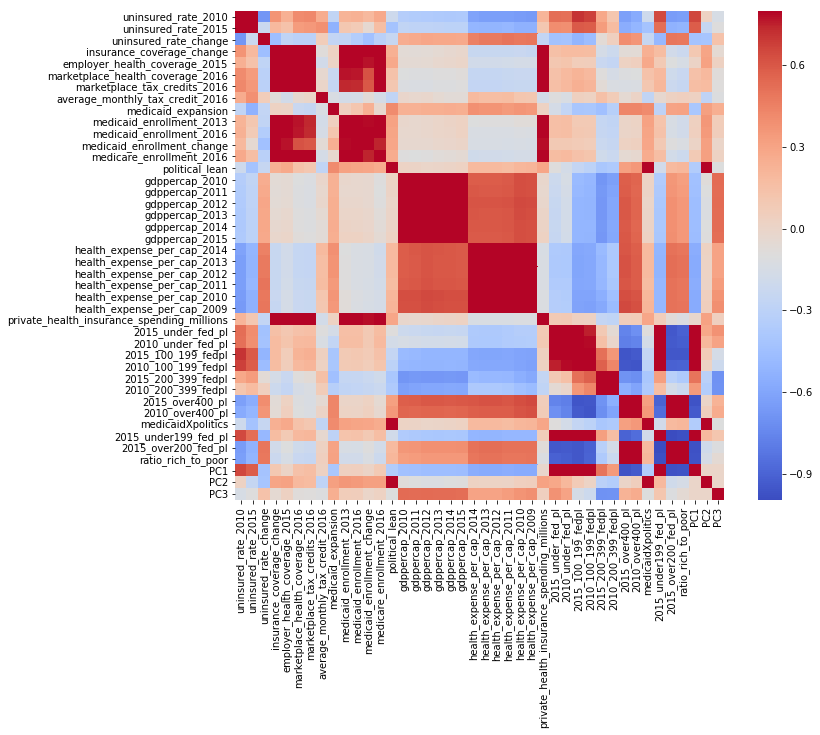

uninsured_rate_change                         1.000000
uninsured_rate_2010                           0.677093
2015_100_199_fedpl                            0.512616
health_expense_per_cap_2011                   0.498907
2015_under199_fed_pl                          0.496695
health_expense_per_cap_2009                   0.496485
2015_over200_fed_pl                           0.494866
health_expense_per_cap_2010                   0.490401
ratio_rich_to_poor                            0.488840
health_expense_per_cap_2013                   0.481453
health_expense_per_cap_2012                   0.481453
2010_100_199_fedpl                            0.467727
health_expense_per_cap_2014                   0.455196
insurance_coverage_change                     0.454530
medicaid_enrollment_change                    0.441360
2015_under_fed_pl                             0.432882
PC1                                           0.426520
2010_under_fed_pl                             0.424199
PC2       

In [11]:
# Make the correlation matrix.
corrmatrix = state_aca_df.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmatrix, vmax=.8, square=True, cmap='coolwarm')
plt.show()

print(corrmatrix['uninsured_rate_change'].abs().sort_values(ascending=False))

Top 5 are:

uninsured_rate_2010                           0.677093
2015_100_199_fedpl                            0.512616
health_expense_per_cap_2011                   0.498907
2015_under199_fed_pl                          0.496695
health_expense_per_cap_2009                   0.496485

I've picked these as they are the most correlated with the outcome variable.

In [12]:
#might be better to create a categorical variable that includes neutral states
uninsured_change_cat=[]

for row in state_aca_df['uninsured_rate_change']:
    if row >=-10.3 and row <=-8.6:
        uninsured_change_cat.append(10)
    elif row <= -6.7 and row >=-8.6:
        uninsured_change_cat.append(9)
    elif row <= -6.3 and row >=-6.7:
        uninsured_change_cat.append(8)
    elif row <= -5.7 and row >=-6.3:
        uninsured_change_cat.append(7)
    elif row <= -5.0 and row >=-5.7:
        uninsured_change_cat.append(6)
    elif row <= -4.7 and row >=-5.0:
        uninsured_change_cat.append(5)
    elif row <= -4.2 and row >=-4.7:
        uninsured_change_cat.append(4)
    elif row <= -3.8 and row >=-4.2:
        uninsured_change_cat.append(3)
    elif row <= -3.3 and row -3.8:
        uninsured_change_cat.append(2)
    elif row >= -3.3:
        uninsured_change_cat.append(1)
    
    #create a column based on this output
state_aca_df['uninsured_change_cat'] = uninsured_change_cat

#print(state_aca_df['uninsured_change_cat'])

------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------

# Modelling:

The following sections employ a number of models, in order to find the model that most accurately describes the change in the percentage of uninsured individuals post ACA.

Decision's Trees,
Random Forest, 
Gradient Boost,
Linear regression (and if appropriate other forms of regression),
Support Vector Machines,
K-nearest neighbors.

For each model, we will employ the following where relevant:

Create a test-train split to test the model against overfitting.
Evaluation metrics: cross-validation scores on the training data, as well as confusion matricies.
Feature assessment and tweaking via PCA, GridSearchCV (where appropriate)

Our ideal outcome model will:

High predictive accuracy in predicting % change in uninsured individuals.
Allow us to attribute the predictive accuracy of the model to particular features.

## Final feature dataset and outcomes:

The full notebook has considerable extra notes and analyses on the inclusion of these variables. In short, the variables included below offer the best compromise between descriptive power, dimensionality and actual tested outcomes. 

With regards our outcome variable, two outcome variables are detailed below. Y1 is the change in % uninsured individuals organized into categories that reflect the decile the fit into. This Y1 outcome is used in classifier models. It should be noted that any classifier models that have predictive accuracy in this analysis should be treated with caution due to the loss of resolution that results from coding this outcome at the decile level. Y1 is the raw change in % of individuals uninsured and is used in all regression models.

In [13]:
from sklearn.model_selection import train_test_split

finalmodel_df=pd.DataFrame()

finalmodel_df['health_expense_per_cap_2012']=state_aca_df['health_expense_per_cap_2012']
finalmodel_df['ratio_rich_to_poor']=state_aca_df['ratio_rich_to_poor']
finalmodel_df['uninsured_rate_2010']=state_aca_df['uninsured_rate_2010']
finalmodel_df['political_lean']=state_aca_df['political_lean']
finalmodel_df['medicaid_expansion']=state_aca_df['medicaid_expansion']



X = finalmodel_df
X = X.dropna(axis=1)
Y= state_aca_df['uninsured_rate_change']
Y1 = state_aca_df['uninsured_change_cat']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1)
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y1, test_size=0.7, random_state=1)


<h1><center>Decision trees</center></h1>

In [14]:
# This is the starting model we will use
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [15]:
#try grid search here

# let's try gridsearch here...
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# A convenience for displaying visualizations.
from IPython.display import Image
import time
start_time = time.time()


# Initialize and train our tree using gridsearchcv

decision_tree = tree.DecisionTreeRegressor()
parameters = {'criterion': ['mse', 'friedman_mse', 'mae'], 'splitter': ['best', 'random'],'max_features': [2, 3], 'max_depth':[2,3,4, 5]}
gridsearch  = GridSearchCV(estimator=decision_tree, param_grid=parameters, cv=4, n_jobs=-1)

gridsearch.fit(X, Y)

print("Best score: %0.3f" % gridsearch.best_score_)
print("Best parameters set:")
best_parameters=gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.613
Best parameters set:
	criterion: 'friedman_mse'
	max_depth: 3
	max_features: 2
	splitter: 'best'


D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score is 0.636 -> 

In [16]:

# Initialize and train our tree.
decision_tree = tree.DecisionTreeRegressor(
    criterion='friedman_mse',
    max_features=3,
    max_depth=5,
    splitter='best'
)

decision_tree.fit(X_train, Y_train)

y_pred = decision_tree.predict(X_test)

decision_tree.score(X_test, Y_test)


-0.11688586194768757

In [17]:
import graphviz 
dot_data = tree.export_graphviz(decision_tree, out_file='tree.dot') 

<img src="decisiontree.png">

<h1><center>Random Forest</center></h1>

In [18]:
import time
start_time = time.time()

rf= ensemble.RandomForestRegressor()

parameters = {'n_estimators':[10,20,40,80], 'criterion': ['mse', 'friedman_mse', 'mae'],'max_features': [2, 3], 'max_depth':[2,3,4, 5]}
gridsearch  = GridSearchCV(estimator=rf, param_grid=parameters, cv=4, n_jobs=-1)

gridsearch.fit(X, Y)

print("Best score: %0.3f" % gridsearch.best_score_)
print("Best parameters set:")
best_parameters=gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.650
Best parameters set:
	criterion: 'mse'
	max_depth: 4
	max_features: 2
	n_estimators: 20


D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
rf=ensemble.RandomForestRegressor(n_estimators= 20, criterion='friedman_mse', max_features=2, max_depth=4)

rf.fit(X_train, Y_train)

rf.score(X_test, Y_test)

0.35969770975702964

The code below ouputs the trees from the forest.

In [20]:
estimator = rf.estimators_[13]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='rf13.dot', 
                rounded = True, proportion = False, 
                precision = 2, filled = True)

<h1><center>Multivariable Linear Regression</center></h1>

In [21]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

In [22]:

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 4.15031566e-04  5.71305534e-01 -2.91405617e-01 -7.12066612e-01
 -2.03242148e+00]

Intercept: 
 -4.039735840194501

R-squared:
0.7814266713082993


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=1)

In [24]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_train, Y_train))


Coefficients: 
 [ 2.68271859e-04  8.25391655e-01 -3.04841180e-01 -9.55726775e-01
 -1.95888463e+00]

Intercept: 
 -3.1690328138888604

R-squared:
0.7897148641705758


In [25]:
print(regr.score(X_test, Y_test))

0.708359427995467


Our multivariable regression model is the best to date and by a large margin. Let's take a look at how the variables we've included correlate with our outcome variable:

finalmodel_df['health_expense_per_cap_2012']=state_aca_df['health_expense_per_cap_2012']
finalmodel_df['ratio_rich_to_poor']=state_aca_df['ratio_rich_to_poor']
finalmodel_df['uninsured_rate_2010']=state_aca_df['uninsured_rate_2010']
finalmodel_df['political_lean']=state_aca_df['political_lean']
finalmodel_df['medicaid_expansion']=state_aca_df['medicaid_expansion']

Text(0, 0.5, '')

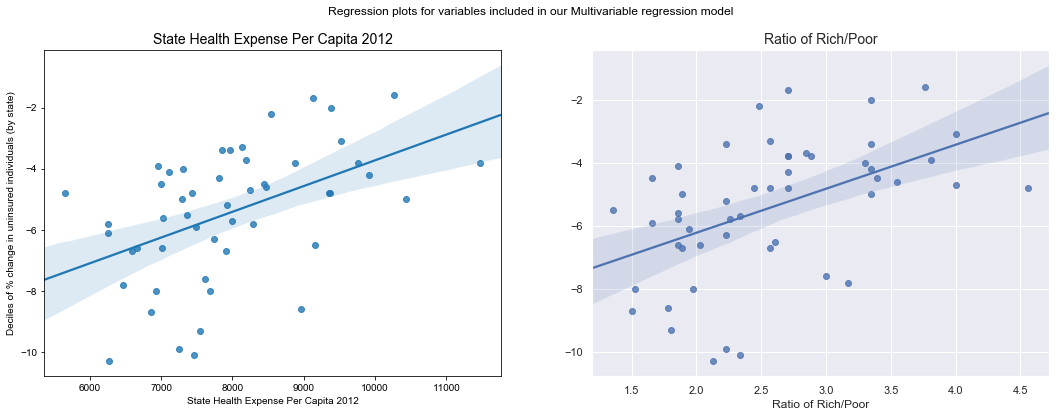

In [26]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.suptitle('Regression plots for variables included in our Multivariable regression model')
sns.set(style="darkgrid")
sns.regplot(state_aca_df['health_expense_per_cap_2012'], Y)
plt.title('State Health Expense Per Capita 2012', fontsize=14)
plt.xlabel('State Health Expense Per Capita 2012')
plt.ylabel('Deciles of % change in uninsured individuals (by state)')

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
sns.regplot(state_aca_df['ratio_rich_to_poor'], Y)
plt.title('Ratio of Rich/Poor', fontsize=14)
plt.xlabel('Ratio of Rich/Poor')
plt.ylabel('')

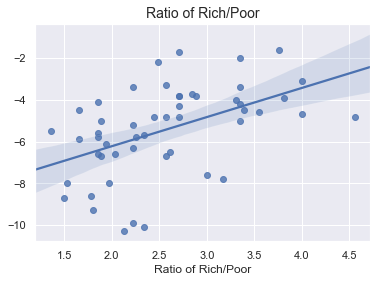

In [27]:

sns.set(style="darkgrid")
sns.regplot(state_aca_df['ratio_rich_to_poor'], Y)
plt.title('Ratio of Rich/Poor', fontsize=14)
plt.xlabel('Ratio of Rich/Poor')
plt.ylabel('')
plt.show()

Text(0, 0.5, '')

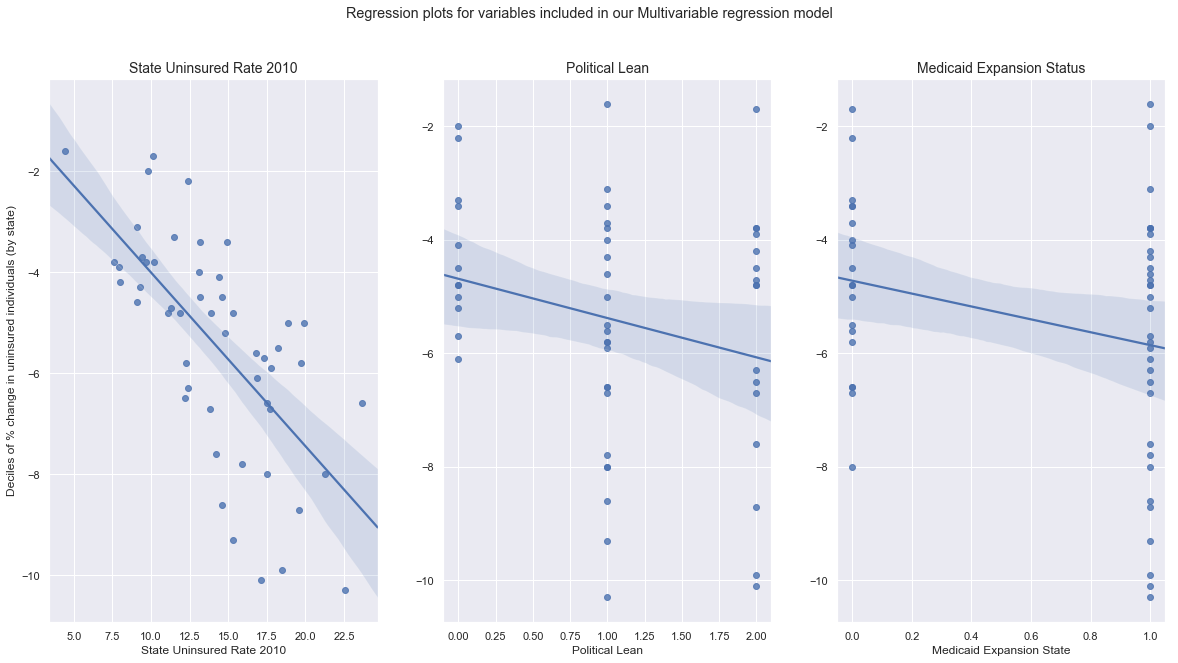

In [28]:
plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)
plt.suptitle('Regression plots for variables included in our Multivariable regression model')
sns.set(style="darkgrid")
sns.regplot(state_aca_df['uninsured_rate_2010'], Y)
plt.title('State Uninsured Rate 2010', fontsize=14)
plt.xlabel('State Uninsured Rate 2010')
plt.ylabel('Deciles of % change in uninsured individuals (by state)')

plt.subplot(1, 3, 2)
sns.set(style="darkgrid")
sns.regplot(state_aca_df['political_lean'], Y)
plt.title('Political Lean', fontsize=14)
plt.xlabel('Political Lean')
plt.ylabel('')

plt.subplot(1, 3, 3)
sns.set(style="darkgrid")
sns.regplot(state_aca_df['medicaid_expansion'], Y)
plt.title('Medicaid Expansion Status', fontsize=14)
plt.xlabel('Medicaid Expansion State')
plt.ylabel('')



<h1><center>Gradient Boost</center></h1>

In [29]:
# Initialize and fit the model.
gbr = ensemble.GradientBoostingRegressor()

#score


parameters = {'max_features': [2,3,4],'loss':['ls', 'lad', 'huber', 'quantile'], 'learning_rate':[0.1, 0.2, 0.4, 0.5,1.0, 2.0], 'n_estimators':[2,4,8,16,20,32]}
gridsearch  = GridSearchCV(estimator=gbr, param_grid=parameters, cv=4, n_jobs=-1)

gridsearch.fit(X, Y)

print("Best score: %0.3f" % gridsearch.best_score_)
print("Best parameters set:")
best_parameters=gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.679
Best parameters set:
	learning_rate: 0.4
	loss: 'huber'
	max_features: 4
	n_estimators: 16


D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [31]:
params = {'learning_rate': 0.2,
          'loss': 'ls',
          'n_estimators': 8,
         'max_features': 4}

# Initialize and fit the model.
gbr = ensemble.GradientBoostingRegressor(**params)
gbr.fit(X_train, Y_train)

predict_train = gbr.predict(X)

#score
gbr.score(X_test, Y_test)

0.2720033627702597

Given the lack of data here, it's almost impossible not to overfit in most of these models - apart from simple regression. We're really going to have to try smote. There's no point trying to optimize these models any further as they will not out perform our regression model.

<h1><center>Support Vector Machines</center></h1>

Didn't use GridSearchCV here because it makes the notebook instance crash.

In [36]:
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf')

svr.fit(X_train,Y_train)

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
svr.score(X_test, Y_test)

0.6080313547031694